## Activation Energy and Pre-exponential Factors

Necessary imports

In [264]:
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
import scipy.io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

#### Constants and Labels

In [265]:
# Input temperatures
temperatures = np.array([450., 460., 470., 475., 480., 490.])
# Inverse temperature as input for LR
inverse_temperatures = 1/temperatures
# Number of temperatures
N = len(temperatures)
# Ideal gas constant in kcal/(mol·K)
R_constant = 0.001987204258 
# for plotting
labels = ['Adsorption R1', 'Adsorption R2', 'Desorption R23','Desorption R14']

#### Load Data

In [266]:
# Results from Pyomo
k_pyomo = scipy.io.loadmat('../data/k_pyomo.mat')
k_pyomo = k_pyomo['k']


In [267]:
# Results from pMCMC
k_pmcmc = scipy.io.loadmat('../data/k_pmcmc.mat')
k_pmcmc = [k_pmcmc['k1_ads'],k_pmcmc['k2_ads'],k_pmcmc['k3_des'],k_pmcmc['k4_des'] ]

### Linear Regression function for linearized Arrhenius equation

In [268]:
# Linearize Arrhenius eq and fit regression
def linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants, R_constant):

    # Input to -1/RT
    x =- inverse_temperatures/R_constant
    
    # Take the natural log of the rate constants
    ln_k = np.log(rate_constants)

    # Linear regression on ln(k) vs - 1/RT
    Ea, lnA, _, _, Ea_se = linregress(x, ln_k)

    # Compute standard error for lnA
    lnA_se = Ea_se * np.sqrt(1/N + np.mean(x)**2 / np.sum((x - np.mean(x))**2))


    return [Ea, lnA, Ea_se, lnA_se]

### Nonlinear Regression function for Arrhenius equation

In [269]:
# Arrhenius function to fit
def arrhenius_eq(T, A, Ea):
    return A * np.exp(-Ea / (R_constant * T))

Linearized results PYOMO vs PMCMC

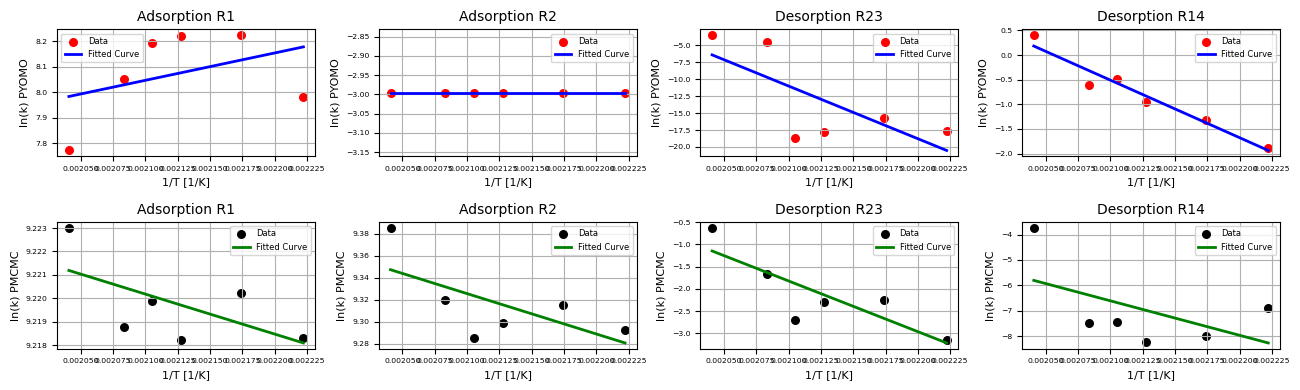

In [270]:
# Initialize lists for storing
Ea = []
lnA = []
se = []

# 4 different rate constants
R = 4

# Temperature for fitting
T_fit = np.linspace(min(temperatures), max(temperatures), 100)

# Create subplots: 2 rows (pyomo + pmcmc) x  4 columns (k1_ads, k2_ads, k3_des, k4_des)
fig, axes = plt.subplots(2, 4, figsize=(13, 4))
axes = axes.flatten()   

# For
for r in range(R):
    # Convert to numpy for computing
    rate_constants_pyomo = np.array(k_pyomo[r], dtype=float) 
    rate_constants_pmcmc = np.array(k_pmcmc[r], dtype=float) 

    # Linear Fit using fn defined above
    Ea_pyomo, lnA_pyomo, stdEa_pyomo, stdlnA_pyomo = linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants_pyomo, R_constant)
    Ea_pmcmc, lnA_pmcmc, stdEa_pmcmc, stdlnA_pmcmc = linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants_pmcmc, R_constant)

    # Store results and errors
    Ea.append([Ea_pyomo, Ea_pmcmc])
    lnA.append([lnA_pyomo, lnA_pmcmc])
    se.append([[stdEa_pyomo, stdlnA_pyomo], [stdEa_pmcmc, stdlnA_pmcmc]])

    # Create fitted data for plotting
    lnk_fit_pyomo = - Ea_pyomo/(T_fit*R_constant) + lnA_pyomo
    lnk_fit_pmcmc = - Ea_pmcmc/(T_fit*R_constant) + lnA_pmcmc


    # Plot in corresponding subplot
    ax = axes[r]
    ax.scatter(inverse_temperatures, np.log(rate_constants_pyomo), color='red', label='Data', s=30)  # Data points
    ax.plot(1/T_fit, lnk_fit_pyomo, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('1/T [1/K]', fontsize=8)
    ax.set_ylabel('ln(k) PYOMO', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=5.5)
    ax.legend(fontsize=6)
    ax.grid()

     # Plot in corresponding subplot
    ax = axes[4+r]
    ax.scatter(inverse_temperatures, np.log(rate_constants_pmcmc), color='k', label='Data', s=30)  # Data points
    ax.plot(1/T_fit, lnk_fit_pmcmc, color='green', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('1/T [1/K]', fontsize=8)
    ax.set_ylabel('ln(k) PMCMC', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=5.5)
    ax.legend(fontsize = 6)
    ax.grid()

# Formatting
plt.subplots_adjust(hspace=0.1, wspace=0.55) 
plt.tight_layout()


### Pyomo Results from Linear Fitting

In [271]:
for r in range(R):
    print(f'R{r+1}: Activation Energy   Ea = ',round(Ea[r][0],4),'+/-', round(se[r][0][0],4), '  and Pre-exponential   lnA =', round(lnA[r][0],4),'+/-', round(se[r][0][1],4))

R1: Activation Energy   Ea =  -2.1332 +/- 2.516   and Pre-exponential   lnA = 5.7929 +/- 36.8635
R2: Activation Energy   Ea =  0.0 +/- 0.0   and Pre-exponential   lnA = -2.9957 +/- 0.0
R3: Activation Energy   Ea =  154.5104 +/- 74.7057   and Pre-exponential   lnA = 152.2703 +/- 1094.5483
R4: Activation Energy   Ea =  23.2331 +/- 2.8203   and Pre-exponential   lnA = 24.0446 +/- 41.3214


### PMCMC Results from Linear Fitting

In [272]:
for r in range(R):
    print(f'R{r+1}: Activation Energy   Ea = ',round(Ea[r][1],4),'+/-', round(se[r][1][0],4), '  and Pre-exponential   lnA =', round(lnA[r][1],4),'+/-', round(se[r][1][1],4))

R1: Activation Energy   Ea =  0.0339 +/- 0.0219   and Pre-exponential   lnA = 9.256 +/- 0.3202
R2: Activation Energy   Ea =  0.7273 +/- 0.4212   and Pre-exponential   lnA = 10.0943 +/- 6.1717
R3: Activation Energy   Ea =  22.6774 +/- 7.3952   and Pre-exponential   lnA = 22.1409 +/- 108.3506
R4: Activation Energy   Ea =  26.9904 +/- 21.32   and Pre-exponential   lnA = 21.9129 +/- 312.37


## Nonlinear Regression Results

Remark: The results are very sensitive to the initial guesses. While we did use the results from the linear fitting as initial guesses for the nonlinear fitting, in few cases the curve fitting did not converge and we initialized the guessses manually by trial and error. We note there may be better initial guesses, but at the present moment these results were the best we could obtain.

C:\Users\ilosk\AppData\Local\Temp\ipykernel_20260\775712655.py:38: OptimizeWarning: Covariance of the parameters could not be estimated
  params_pyomo, covariance_pyomo = curve_fit(arrhenius_eq, temperatures, rate_constants_pyomo, p0=init_pyomo)
C:\Users\ilosk\AppData\Local\Temp\ipykernel_20260\3181536074.py:3: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-Ea / (R_constant * T))


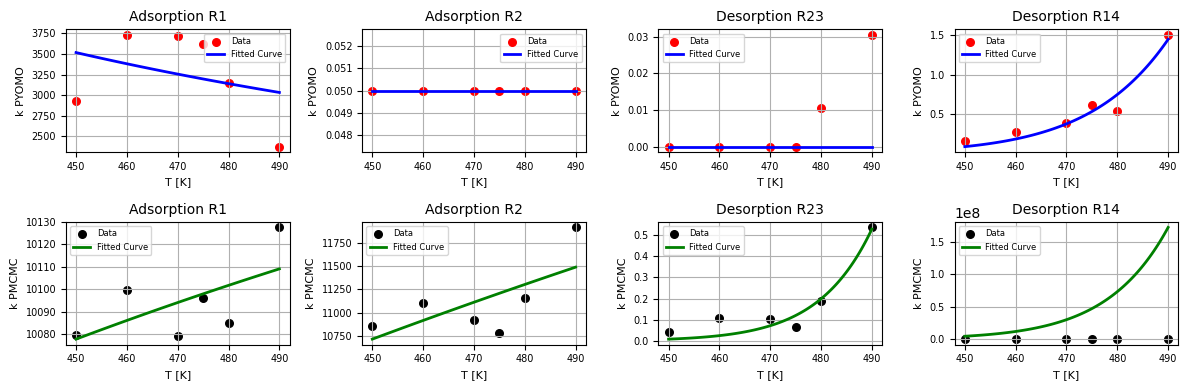

In [288]:
# Initial Guesses

# Manual guessing for R3, res from linear fitting for the rest
# Ea_init_pyomo = [Ea[0][0],Ea[1][0],2,Ea[3][0]]
# A_init_pyomo = [np.exp(lnA[0][0]), np.exp(lnA[1][0]), 0.05, np.exp(lnA[3][0])]
Ea_init_pyomo = [Ea[0][0],Ea[1][0], 100, Ea[3][0]]
A_init_pyomo = [np.exp(lnA[0][0]), np.exp(lnA[1][0]), 1e5, np.exp(lnA[3][0])]

# The results from the linear fitting as initial guesses - does not converge for all regions
# Ea_init_pmcmc = [Ea[0][1],Ea[1][1],Ea[2][1],Ea[3][1]]
# A_init_pmcmc = [np.exp(lnA[0][1]), np.exp(lnA[1][1]), np.exp(lnA[2][1]), np.exp(lnA[3][1])]

# Manual guessing for R3 and R4
Ea_init_pmcmc = [Ea[0][1],Ea[1][1], 40, 40]
A_init_pmcmc = [np.exp(lnA[0][1]), np.exp(lnA[1][1]), 1e10, 1e40]

# List for storing results
Ea_nl = []
A_nl = []
se_nl = []

# Subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 4))
axes = axes.flatten()  

for r in range(R):

    
    # Convert to numpy arrays to compute
    rate_constants_pyomo = np.array(k_pyomo[r], dtype=float)
    rate_constants_pmcmc = np.array(k_pmcmc[r], dtype=float)

    # Initial guess for [A, Ea]
    init_pyomo = [A_init_pyomo[r], Ea_init_pyomo[r]]  # Example initial guess for A and Ea
    init_pmcmc = [A_init_pmcmc[r], Ea_init_pmcmc[r]]

    # Perform nonlinear regression
    params_pyomo, covariance_pyomo = curve_fit(arrhenius_eq, temperatures, rate_constants_pyomo, p0=init_pyomo)
    params_pmcmc, covariance_pmcmc = curve_fit(arrhenius_eq, temperatures, rate_constants_pmcmc[0], p0=init_pmcmc)

    # Extract fitted parameters
    A_fit_pyomo, Ea_fit_pyomo = params_pyomo
    A_fit_pmcmc, Ea_fit_pmcmc = params_pmcmc

    Ea_nl.append([Ea_fit_pyomo, Ea_fit_pmcmc])
    A_nl.append([A_fit_pyomo, A_fit_pmcmc])

    # Calculate standard errors
    std_errors_pyomo = np.sqrt(np.diag(covariance_pyomo))
    std_errors_pmcmc = np.sqrt(np.diag(covariance_pmcmc))


    se_nl.append([std_errors_pyomo, std_errors_pmcmc])

    # Optional: plot the results
    T_fit = np.linspace(min(temperatures), max(temperatures), 100)
    k_fit_pyomo = arrhenius_eq(T_fit, *params_pyomo)
    k_fit_pmcmc = arrhenius_eq(T_fit, *params_pmcmc)

    # Plot in corresponding subplot
    ax = axes[r]
    ax.scatter(temperatures, rate_constants_pyomo, color='red', label='Data', s=30)  # Data points
    ax.plot(T_fit, k_fit_pyomo, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('T [K]', fontsize=8)
    ax.set_ylabel('k PYOMO', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize = 6)
    ax.grid()

        # Plot in corresponding subplot
    ax = axes[r+4]
    ax.scatter(temperatures, rate_constants_pmcmc, color='k', label='Data', s=30)  # Data points
    ax.plot(T_fit, k_fit_pmcmc, color='green', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax.set_xlabel('T [K]', fontsize=8)
    ax.set_ylabel('k PMCMC', fontsize=8)
    ax.set_title(labels[r], fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.legend(fontsize = 6)
    ax.grid()

# Plot layout formatting
plt.subplots_adjust(hspace=0.1, wspace=0.55) 
plt.tight_layout()


### Pyomo Results from Curve Fitting

In [289]:
for r in range(R):
    print(f'R{r+1}: Activation Energy   Ea = ',round(Ea_nl[r][0],4),'+/-', round(se_nl[r][0][1],4), '  and Pre-exponential factor   A =', round(A_nl[r][0],4),'+/-', round(se_nl[r][0][0],4))

R1: Activation Energy   Ea =  -1.6266 +/- 2.3771   and Pre-exponential factor   A = 570.4713 +/- 1455.2209
R2: Activation Energy   Ea =  0.0 +/- 0.0   and Pre-exponential factor   A = 0.05 +/- 0.0
R3: Activation Energy   Ea =  100.0 +/- inf   and Pre-exponential factor   A = 100000.0 +/- inf
R4: Activation Energy   Ea =  30.9003 +/- 4.7025   and Pre-exponential factor   A = 87475094647589.8 +/- 426436343354169.7


### PMCMC Results from Curve Fitting

In [263]:
for r in range(R):
    print(f'R{r+1}: Activation Energy   Ea = ',round(Ea_nl[r][1],4),'+/-', round(se_nl[r][1][1],4), '  and Pre-exponential factor   A =', round(A_nl[r][1],4),'+/-', round(se_nl[r][1][0],4))

R1: Activation Energy   Ea =  0.0339 +/- 0.0219   and Pre-exponential factor   A = 10467.8107 +/- 244.9647
R2: Activation Energy   Ea =  0.7617 +/- 0.429   and Pre-exponential factor   A = 25118.004 +/- 11515.3161
R3: Activation Energy   Ea =  45.7213 +/- 8.6761   and Pre-exponential factor   A = 1.3046382367941778e+20 +/- 1.1668482652868815e+21
R4: Activation Energy   Ea =  40.0 +/- 0.0   and Pre-exponential factor   A = 1.1913109790229356e+26 +/- 4.989416649152719e+27
